In [ ]:
# https://statcompute.wordpress.com/2017/01/08/an-example-of-merge-layer-in-keras/

In [1]:
from sklearn.utils import class_weight

from sklearn.model_selection import train_test_split
import numpy as np
from keras.models import Sequential
from keras.layers import Dense,Merge
from keras.layers import LSTM

# For the plots 
import matplotlib.pyplot as plt

# For controlling the training parameters in the midst of training itself
from keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau

# For creating directory to save the models
import os

Using TensorFlow backend.


In [2]:
# Load the data
X = np.load("X (1).npy")
Y = np.load("Y (1).npy")

In [3]:
# Split the test train and pass it into validation

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [4]:
X_test[:,:100]

array([[ 0.02168554, -1.0548047 ,  0.40987068, ..., -0.30923844,
         0.35082002, -1.92649141],
       [-0.15416558, -0.11757356,  0.45027281, ...,  0.50488142,
         0.79703528, -0.81547943],
       [ 0.19885802, -1.2065653 , -1.64577139, ...,  4.01158599,
         0.40503207,  1.13326333],
       ..., 
       [-0.4378321 , -1.64126673,  0.6659438 , ...,  0.72965238,
         1.40637856, -1.41041953],
       [-1.29651088, -1.74769129,  0.39096358, ...,  1.08826687,
        -1.24826029,  2.69560618],
       [-1.62809107, -1.02241376,  1.60640286, ...,  0.3292707 ,
        -2.03422071,  0.64199374]])

In [5]:
# Reshape the stuff according to the the shape Keras expects it to be !
data_lstm = X_train[:,:100].reshape((X_train[:,:100].shape[0], 100, 1))
target = Y_train.reshape((Y_train.shape[0], 1))

val_data_lstm = X_test[:,:100].reshape(X_test[:,:100].shape[0],100,1)
val_target = Y_test.reshape(Y_test.shape[0],1)

In [6]:
data_lstm.shape

(2923, 100, 1)

In [7]:
data_mw = X_train[:,-1].reshape((X_train[:,-1].shape[0],1))
val_data_mw = X_test[:,-1].reshape((X_test[:,-1].shape[0],1))

In [8]:
val_data_mw.shape

(325, 1)

In [9]:
val_target.shape

(325, 1)

In [57]:
# The standard model
# Here 50, the dimensionality of the output from LSTM is just a random no and has no suxh signifance, 
# That ^^ shuould be search via a hyperparameter search

branch1 = Sequential()

# The a<final output> will have 50 numbers 
branch1.add(LSTM(50, input_shape=(100, 1)))

branch2 = Sequential()
branch2.add(Dense(10,input_dim=1))
# Get those 50 numbers and put that into one output !
model =Sequential()
model.add(Merge([branch1, branch2], mode = 'concat'))
model.add(Dense(1,activation='tanh'))
model.add(Dense(1,activation='relu'))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  


In [58]:
# Define the output for the saving the checkpoint (best models)

outputFolder = './output-lstm'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
filepath=outputFolder+"/Weights-{epoch:02d}-{val_acc:.2f}.hdf5"

In [59]:
# The callback function for model checkpoint saving
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1,save_best_only=True,\
                             save_weights_only=True,mode='auto')

# The callback function for earlystopping

earlystop = EarlyStopping(monitor='val_loss',patience=10, \
                          verbose=1, mode='auto')

# The callback function for reducing learning rate on plateus

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00001)

In [60]:
# Put all those calback in a list
callbacks = [earlystop, checkpoint, reduce_lr]

In [61]:
# I have decided to use mean_absolute_error , beacuse for some reason mean squared e
model.compile(loss='mean_absolute_error', optimizer='adam',metrics=['accuracy'])
model_info = model.fit([data_lstm,data_mw], target, nb_epoch=10000, batch_size=1000, verbose=2,validation_data=([val_data_lstm,val_data_mw],val_target),
                   callbacks=callbacks)

/home/sangeet/.local/lib/python3.5/site-packages/keras/models.py:944: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 2923 samples, validate on 325 samples
Epoch 1/10000

Epoch 00001: val_acc improved from -inf to 0.80000, saving model to ./output-lstm/Weights-01-0.80.hdf5
 - 2s - loss: 3.1573 - acc: 0.7988 - val_loss: 3.8501 - val_acc: 0.8000
Epoch 2/10000

Epoch 00002: val_acc did not improve
 - 1s - loss: 3.1459 - acc: 0.7999 - val_loss: 3.8370 - val_acc: 0.8000
Epoch 3/10000

Epoch 00003: val_acc improved from 0.80000 to 0.80308, saving model to ./output-lstm/Weights-03-0.80.hdf5
 - 1s - loss: 3.1338 - acc: 0.8019 - val_loss: 3.8247 - val_acc: 0.8031
Epoch 4/10000

Epoch 00004: val_acc did not improve
 - 1s - loss: 3.1221 - acc: 0.8023 - val_loss: 3.8141 - val_acc: 0.8031
Epoch 5/10000

Epoch 00005: val_acc did not improve
 - 1s - loss: 3.1127 - acc: 0.8029 - val_loss: 3.8068 - val_acc: 0.8031
Epoch 6/10000

Epoch 00006: val_acc did not improve
 - 1s - loss: 3.1073 - acc: 0.8033 - val_loss: 3.8039 - val_acc: 0.8031
Epoch 7/10000

Epoch 00007: val_acc did not improve
 - 1s - loss: 3.1054 -

In [62]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

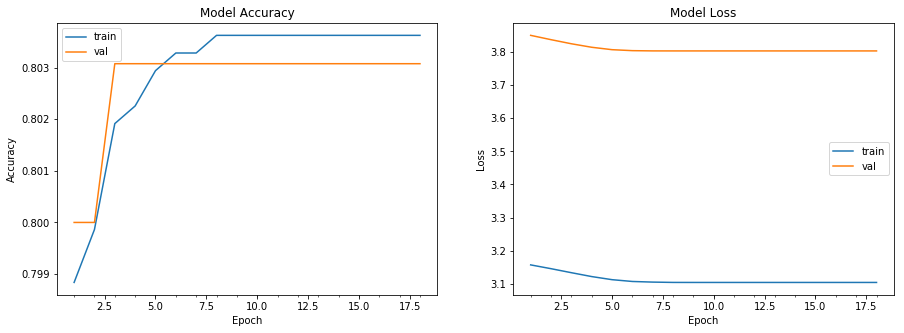

In [63]:
plot_model_history(model_info)

In [64]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(val_target, model.predict([val_data_lstm,val_data_mw]))

In [65]:
mse*19/200

25.412646153846154

In [66]:
mean_squared_error(target,model.predict([data_lstm,data_mw]))*19/200

15.973650359219977